# Strategy Description: Commodity Cross-Sectional Momentum

### 1. Executive Summary
This strategy applies a **Cross-Sectional Momentum** approach to Gold and Silver.

The core premise is that commodities with strong recent performance (Winners) tend to continue outperforming those with weak performance (Losers), often driven by the "Roll Yield" component (backwardation vs. contango).

### 2. Strategy Logic

#### A. Signal Generation (Ranking)
The strategy calculates a **Momentum Score** for both assets based on their logarithmic returns over a specific lookback window.
* **Lookback Period:** 20 Days (approx. 5,520 bars).
* **Comparison:** At the rebalancing time, the strategy compares the momentum of Gold vs. Silver.

#### B. Position Taking (Long/Short)
The strategy constructs a **Long/Short portfolio** based on the relative strength:
* **Scenario 1 (Gold > Silver):** Buy 1 Unit of Gold / Sell 1 Unit of Silver.
* **Scenario 2 (Silver > Gold):** Buy 1 Unit of Silver / Sell 1 Unit of Gold.
* *Note:* The strategy is always in the market (Long/Short) unless the data period is designated as Out-of-Sample.

#### C. Rebalancing
* **Frequency:** Daily (every 276 bars).
* **Rationale:** Rebalancing is restricted to once a day to minimize transaction costs and avoid "noise" inherent in 5-minute data.

### 3. Risk Management & Constraints

* **Position Sizing:**
    Strictly limited to **1 Unit per asset**. This avoids over-leveraging and keeps the logic purely focused on directional accuracy rather than sizing optimization.
* **Out-of-Sample (OOS) Handling:**
    To ensure robust testing, trading is strictly prohibited during OOS periods. Positions are forced to **Flat (0)** during these gaps to prevent data leakage and unrealistic equity curve interpolation.

### 4. Performance Metrics
Performance is evaluated on a daily aggregated basis, separated by Quarter, using the following metrics:

* **Sharpe Ratio (Gross/Net):** Risk-adjusted return (Annualized).
* **Calmar Ratio (Gross/Net):** Return relative to Maximum Drawdown (Annualized).
* **Cumulative P&L:** Total monetary profit/loss.
* **Transaction Costs:** Explicitly deducted (Spread + Commission) to calculate Net metrics.

[Info] Preparing momentum with MOMENTUM_WINDOW = 4140
[Info] WARNING: first 4140 rows (per continuous series) will have NaN momentum
[Info] Rows total: 122630, rows with full momentum: 108606
[Info] Simulating Strategy (XAG_THRESHOLD=0.05, REBALANCE_FREQ=4140)...
[Info] Simulated trades (approx): 19.0

 PERFORMANCE REPORT
Quarter  Gross SR    Net SR  Ann. Vol ($)  Gross CR    Net CR  Gross CumP&L  Net CumP&L  Trades (Au)  Trades (Ag)  Av. Trades      Stat
2023_Q1  1.497673  1.490698  21254.577841  6.950591  6.918844        9852.0      9807.0          3.0          0.0    0.038462  2.261859
2023_Q3 -1.684713 -1.696566  16698.798304 -1.590025 -1.595570       -8709.0     -8769.0          2.0          3.0    0.064103 -4.769234
2023_Q4  1.886200  1.876987  25952.357963  4.994326  4.956073       15147.6     15077.6          4.0          1.0    0.064103  3.736056
2024_Q2  2.303625  2.294085  50023.266356 10.823698 10.781740       36115.6     35975.6          8.0          2.0    0.126582  6.427

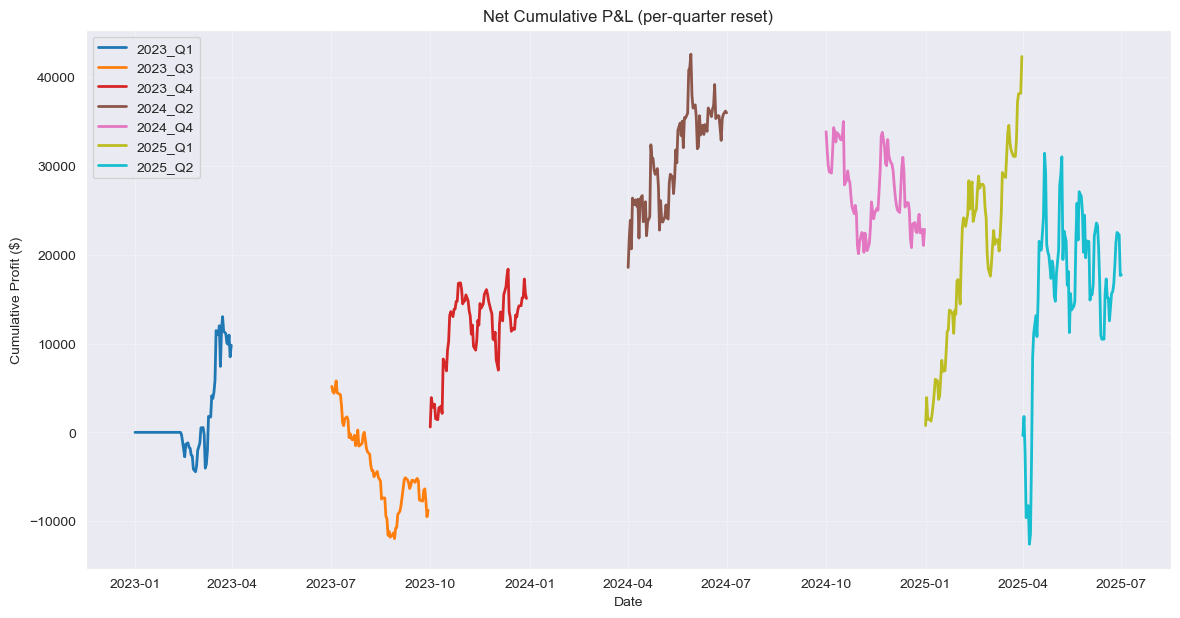

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
import warnings

warnings.filterwarnings('ignore')

# ==========================================
# 1. Configuration
# ==========================================
class Config:
    FILE_PATH = '../../preprocess/df_g2_processed.pkl'
    ASSETS = ['XAU', 'XAG']

    # Contract Specs
    SPECS = {
        'XAU': {'point_val': 100.0, 'cost': 15.0},
        'XAG': {'point_val': 5000.0, 'cost': 10.0}
    }

    # Strategy Parameters
    # NOTE: keep user's original semantics but add robustness knobs below
    MOMENTUM_WINDOW = 276 * 15
    REBALANCE_FREQ = 276 * 15
    ANNUALIZATION = 252

    # Silver Confidence Threshold
    XAG_THRESHOLD = 0.05

    # Robustness knobs
    MIN_MOM_PERIOD = max(1, int(MOMENTUM_WINDOW * 0.05))  # used for info only


# ==========================================
# 2. Data Preparation (robust)
# ==========================================
def prepare_data(file_path, cfg):
    """
    Load df_g2 (CET-naive index), compute momentum continuously
    (do not groupby for the rolling shift to avoid per-quarter annihilation).
    Keep NaNs (momentum not available) rather than dropping them.
    """
    try:
        df = pd.read_pickle(file_path)
    except FileNotFoundError:
        print(f"[Error] File not found: {file_path}")
        return None

    # required columns
    req_cols = set(cfg.ASSETS + ['Quarter_ID'])
    if 'Is_In_Sample' in df.columns:
        req_cols.add('Is_In_Sample')

    missing = req_cols.difference(df.columns)
    if missing:
        print(f"[Error] Missing required columns in {file_path}: {missing}")
        return None

    data = df[list(req_cols)].copy()
    # Keep original ordering of columns for convenience
    # Ensure Is_In_Sample exists
    if 'Is_In_Sample' not in data.columns:
        data['Is_In_Sample'] = True

    print(f"[Info] Preparing momentum with MOMENTUM_WINDOW = {cfg.MOMENTUM_WINDOW}")
    print(f"[Info] WARNING: first {cfg.MOMENTUM_WINDOW} rows (per continuous series) will have NaN momentum")

    # Continuous momentum calculation (log returns over shift)
    # Use global series so history is preserved across quarters
    # Momentum = log(p_t / p_{t - window})
    for asset in cfg.ASSETS:
        col_name = f"{asset}_Mom"
        data[col_name] = np.log(data[asset] / data[asset].shift(cfg.MOMENTUM_WINDOW))

    # Don't drop rows — keep structure. Strategy will skip NaNs.
    n_total = len(data)
    n_valid = data[[f"{a}_Mom" for a in cfg.ASSETS]].dropna().shape[0]
    print(f"[Info] Rows total: {n_total}, rows with full momentum: {n_valid}")

    return data


# ==========================================
# 3. Strategy Logic (unchanged core, robust handling)
# ==========================================
def run_strategy(df, cfg):
    data = df.copy()
    if data.empty:
        print("[Warning] Empty DataFrame passed to run_strategy.")
        return data

    # Ensure Is_In_Sample exists
    if 'Is_In_Sample' not in data.columns:
        data['Is_In_Sample'] = True

    # Extract momentum arrays
    mom_xau = data['XAU_Mom'].values
    mom_xag = data['XAG_Mom'].values
    in_sample = data['Is_In_Sample'].values

    n = len(data)
    pos_xau = np.zeros(n, dtype=int)
    pos_xag = np.zeros(n, dtype=int)
    curr_pos_xau = 0
    curr_pos_xag = 0

    print(f"[Info] Simulating Strategy (XAG_THRESHOLD={cfg.XAG_THRESHOLD}, REBALANCE_FREQ={cfg.REBALANCE_FREQ})...")

    for i in range(n):
        # If not in-sample, reset positions
        if not in_sample[i]:
            curr_pos_xau = 0
            curr_pos_xag = 0
            pos_xau[i] = 0
            pos_xag[i] = 0
            continue

        # Rebalance only at multiples of REBALANCE_FREQ (and at i=0)
        if (i % cfg.REBALANCE_FREQ) == 0:
            m_xau = mom_xau[i]
            m_xag = mom_xag[i]

            # If either momentum is NaN, skip rebalancing (keep current positions)
            if np.isnan(m_xau) or np.isnan(m_xag):
                # keep current positions
                pos_xau[i] = curr_pos_xau
                pos_xag[i] = curr_pos_xag
                continue

            # XAU Logic (momentum comparison)
            if m_xau > m_xag:
                curr_pos_xau = 1
            else:
                curr_pos_xau = -1

            # XAG Logic (High Confidence threshold)
            if m_xag > (m_xau + cfg.XAG_THRESHOLD):
                curr_pos_xag = 1
            elif m_xag < (m_xau - cfg.XAG_THRESHOLD):
                curr_pos_xag = -1
            else:
                curr_pos_xag = 0

        # assign
        pos_xau[i] = curr_pos_xau
        pos_xag[i] = curr_pos_xag

    # Shift positions to simulate execution on next bar (no look-ahead)
    data['Pos_XAU'] = pd.Series(pos_xau, index=data.index).shift(1).fillna(0).astype(int)
    data['Pos_XAG'] = pd.Series(pos_xag, index=data.index).shift(1).fillna(0).astype(int)

    # Quick summary
    n_trades = (data['Pos_XAU'].diff().abs().sum() + data['Pos_XAG'].diff().abs().sum()) / 2.0
    print(f"[Info] Simulated trades (approx): {n_trades}")

    return data


# ==========================================
# 4. P&L Calculation & Aggregation
# ==========================================
def calculate_metrics(data, cfg):
    df = data.copy()
    if df.empty:
        return pd.DataFrame()

    # Price diffs
    df['dPrice_XAU'] = df['XAU'].diff()
    df['dPrice_XAG'] = df['XAG'].diff()

    # Gross PnL (position * price change * point)
    df['Gross_PnL_XAU'] = df['Pos_XAU'] * df['dPrice_XAU'] * cfg.SPECS['XAU']['point_val']
    df['Gross_PnL_XAG'] = df['Pos_XAG'] * df['dPrice_XAG'] * cfg.SPECS['XAG']['point_val']
    df['Gross_PnL_Total'] = df['Gross_PnL_XAU'].fillna(0) + df['Gross_PnL_XAG'].fillna(0)

    # Trades & costs
    df['Trades_XAU'] = df['Pos_XAU'].diff().abs().fillna(0)
    df['Trades_XAG'] = df['Pos_XAG'].diff().abs().fillna(0)
    df['Cost_Total'] = (df['Trades_XAU'] * cfg.SPECS['XAU']['cost']) + (df['Trades_XAG'] * cfg.SPECS['XAG']['cost'])

    df['Net_PnL_Total'] = df['Gross_PnL_Total'] - df['Cost_Total']
    df['Total_Trades'] = df['Trades_XAU'] + df['Trades_XAG']

    # Daily aggregation
    daily_stats = df.resample('D').agg({
        'Gross_PnL_Total': 'sum',
        'Net_PnL_Total': 'sum',
        'Total_Trades': 'sum',
        'Trades_XAU': 'sum',
        'Trades_XAG': 'sum',
        'Quarter_ID': 'last',
        'Is_In_Sample': 'last'
    })

    # Keep only valid quarter days and in-sample
    daily_stats = daily_stats[daily_stats['Quarter_ID'].notna()]
    daily_stats = daily_stats[daily_stats['Is_In_Sample'] == True]

    return daily_stats


# ==========================================
# 5. Reporting & Metrics
# ==========================================
def generate_quarterly_stats(daily_df, cfg):
    if daily_df.empty:
        return pd.DataFrame()

    quarters = sorted(daily_df['Quarter_ID'].unique())
    stats_list = []

    for q in quarters:
        d_q = daily_df[daily_df['Quarter_ID'] == q].copy()
        if len(d_q) == 0:
            continue

        gross_cum_pnl = d_q['Gross_PnL_Total'].sum()
        net_cum_pnl = d_q['Net_PnL_Total'].sum()

        mean_g = d_q['Gross_PnL_Total'].mean()
        std_g = d_q['Gross_PnL_Total'].std()
        gross_sr = (mean_g / std_g * np.sqrt(cfg.ANNUALIZATION)) if (std_g and not np.isnan(std_g)) else 0

        mean_n = d_q['Net_PnL_Total'].mean()
        std_n = d_q['Net_PnL_Total'].std()
        net_sr = (mean_n / std_n * np.sqrt(cfg.ANNUALIZATION)) if (std_n and not np.isnan(std_n)) else 0

        ann_vol_n = (std_n * np.sqrt(cfg.ANNUALIZATION)) if (std_n and not np.isnan(std_n)) else 0

        years = len(d_q) / cfg.ANNUALIZATION if cfg.ANNUALIZATION > 0 else 1.0

        # Gross/Net Calmar
        equity_g = d_q['Gross_PnL_Total'].cumsum()
        peak_g = equity_g.cummax()
        max_dd_g = (peak_g - equity_g).max()
        annualized_pnl_g = gross_cum_pnl / years if years > 0 else 0
        gross_cr = (annualized_pnl_g / max_dd_g) if (max_dd_g and max_dd_g > 0) else 0

        equity_n = d_q['Net_PnL_Total'].cumsum()
        peak_n = equity_n.cummax()
        max_dd_n = (peak_n - equity_n).max()
        annualized_pnl_n = net_cum_pnl / years if years > 0 else 0
        net_cr = (annualized_pnl_n / max_dd_n) if (max_dd_n and max_dd_n > 0) else 0

        trades_xau = d_q['Trades_XAU'].sum()
        trades_xag = d_q['Trades_XAG'].sum()
        av_ntrades = d_q['Total_Trades'].mean()

        abs_pnl_scaled = abs(net_cum_pnl) / 1000.0
        log_term = np.log(abs_pnl_scaled) if abs_pnl_scaled > 0 else 0
        term_2 = max(0, log_term)
        stat = (net_sr - 0.5) * term_2

        stats_list.append({
            'Quarter': q,
            'Gross SR': gross_sr,
            'Net SR': net_sr,
            'Ann. Vol ($)': ann_vol_n,
            'Gross CR': gross_cr,
            'Net CR': net_cr,
            'Gross CumP&L': gross_cum_pnl,
            'Net CumP&L': net_cum_pnl,
            'Trades (Au)': trades_xau,
            'Trades (Ag)': trades_xag,
            'Av. Trades': av_ntrades,
            'Stat': stat
        })

    return pd.DataFrame(stats_list)


# ==========================================
# 6. Plotting (per-quarter reset)
# ==========================================
def plot_quarterly_equity(daily_stats):
    if daily_stats is None or daily_stats.empty:
        return

    quarters = sorted(daily_stats['Quarter_ID'].unique())
    colors = plt.cm.tab10(np.linspace(0, 1, len(quarters)))

    plt.figure(figsize=(14, 7))
    for i, q in enumerate(quarters):
        d_q = daily_stats[daily_stats['Quarter_ID'] == q].sort_index()
        equity = d_q['Net_PnL_Total'].cumsum()
        plt.plot(equity.index, equity.values, label=q, color=colors[i], lw=2)

    plt.title('Net Cumulative P&L (per-quarter reset)')
    plt.ylabel('Cumulative Profit ($)')
    plt.xlabel('Date')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()


# ==========================================
# 7. Main Execution
# ==========================================
if __name__ == "__main__":
    cfg = Config()
    df_prep = prepare_data(cfg.FILE_PATH, cfg)

    if df_prep is None or df_prep.empty:
        print("[Error] No data prepared. Exiting.")
    else:
        df_res = run_strategy(df_prep, cfg)
        daily_data = calculate_metrics(df_res, cfg)
        stats_table = generate_quarterly_stats(daily_data, cfg)

        print("\n" + "=" * 80)
        print(" PERFORMANCE REPORT")
        print("=" * 80)

        if not stats_table.empty:
            total_score = stats_table['Stat'].sum()
            total_gross_pnl = stats_table['Gross CumP&L'].sum()
            total_net_pnl = stats_table['Net CumP&L'].sum()
            total_trades_au = stats_table['Trades (Au)'].sum()
            total_trades_ag = stats_table['Trades (Ag)'].sum()

            std_global = daily_data['Net_PnL_Total'].std()
            vol_global = std_global * np.sqrt(cfg.ANNUALIZATION) if not np.isnan(std_global) else 0.0

            display_df = stats_table.copy()
            sum_row = pd.DataFrame([{
                'Quarter': 'TOTAL',
                'Gross SR': np.nan,
                'Net SR': np.nan,
                'Ann. Vol ($)': vol_global,
                'Gross CR': np.nan,
                'Net CR': np.nan,
                'Gross CumP&L': total_gross_pnl,
                'Net CumP&L': total_net_pnl,
                'Trades (Au)': total_trades_au,
                'Trades (Ag)': total_trades_ag,
                'Av. Trades': stats_table['Av. Trades'].mean(),
                'Stat': total_score
            }])

            display_df = pd.concat([display_df, sum_row], ignore_index=True)
            # show text
            print(display_df.to_string(index=False))
            print(f"\nTOTAL RANKING SCORE: {total_score:.4f}")

            # plot
            if not daily_data.empty:
                plot_quarterly_equity(daily_data)
        else:
            print("⚠️ No statistics generated.")
